# TSFS12 Hand-in exercise 5, extra assignment: Deep Q-learning for highway driving

## Initial imports

In [1]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from seaborn import despine

import gym
import highway_env

from dqn_agent import DQN_Agent

In [2]:
# If you prefer plots in an external window
# %matplotlib  

## Utility function

In [3]:
def sliding_mean(r, M):
    """Compute sliding mean over M samples for r"""
    n = len(r)
    r_M = np.zeros(n)
    for k in range(1, n):
        r_M[k] = np.mean(r[np.max((0, k - M + 1)):k])
    r_M[0] = r_M[1]
    return r_M

## The simulator

Create the OpenAI gym environment that will be used throughout the exercise

In [4]:
env = gym.make('highway-v0')

To show how the simulator works, run the simulator with random actions

In [5]:
s = env.reset()
done = False
while not done:
    a = env.action_space.sample()
    s, r, done, info = env.step(a)
    env.render()
env.close()

Available actions are

In [6]:
env.action_type.ACTIONS_ALL

{0: 'LANE_LEFT', 1: 'IDLE', 2: 'LANE_RIGHT', 3: 'FASTER', 4: 'SLOWER'}

## Code skeletons for exercises

### Exercise A.1

### Exercise A.2

Define the neural network model for the functional approximation

![QNN](figs/q_nn.png)

In [7]:
class Q_NN(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(25, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 5),
            nn.ReLU()
        )

    def forward(self, s):
        q = self.layers(self.flatten(s))
        return q

Define an explore-exploit strategy

In [8]:
def explore_exploit(k, eps):
    """Return probability for exploration action, a simple strategy
    
    arguments
      k -- episode number
      eps -- scalar or a tuple (p0, p1, tau)
             if eps is scalar, return constant exploration probability
             if eps is tuple, return exponential decay from p0 to p1 with time-constant tao
    """
    if type(eps) == tuple:
        p0, p1, tau = eps
        p = (p0 - p1) * np.exp(-k / tau) + p1
    else:
        p = eps
    return p

Plot a sample explore/exploit strategy for a 3,000 episode training session.

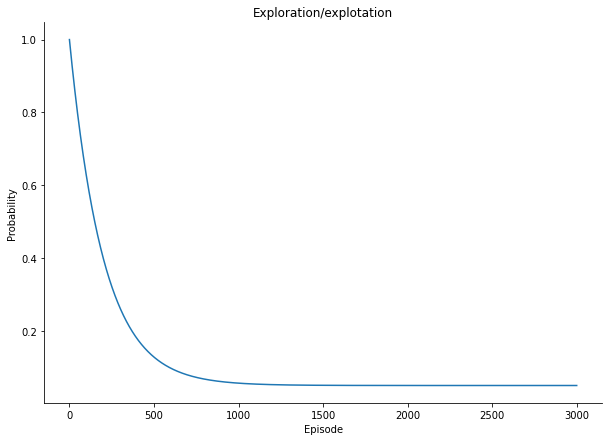

In [9]:
k = np.arange(0, 3000)
plt.figure(figsize=(10, 7))
plt.plot(k, explore_exploit(k, (1.0, 0.05, 200)))
plt.xlabel("Episode")
plt.ylabel("Probability")
plt.title("Exploration/explotation")
despine()

Load the pre-trained model and display model information

In [10]:
opts = {
    "explore_exploit": lambda k: explore_exploit(k, (1.0, 0.05, 200)),
    "gamma": 0.8,
    "batch_size": 32
}

pre_trained = DQN_Agent(env, Q_NN, opts)
pre_trained.load("models/pre-trained/last_model.tar")
pre_trained.eval()  # Put the agent into non-training mode

Loaded model weights from file models/pre-trained/last_model.tar
Loaded stats from file models/pre-trained/stats.json


In [11]:
pre_trained.summary()

Layer (type:depth-idx)                   Param #
Q_NN                                     --
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       6,656
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       65,792
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       1,285
│    └─ReLU: 2-6                         --
Total params: 73,733
Trainable params: 73,733
Non-trainable params: 0

### Exercise A.3

Define an agent

In [12]:
opts = {
    "explore_exploit": lambda k: explore_exploit(k, (1.0, 0.05, 200)),
    "gamma": 0.8,
    "batch_size": 32
}

agent = DQN_Agent(env, Q_NN, opts)

and train for a few episodes

In [13]:
agent.train(10, display=True)

Episode 1 (p=1.000) ... total reward 21.4
Episode 2 (p=0.995) ... total reward 22.5
Episode 3 (p=0.991) ... total reward 4.0
Episode 4 (p=0.986) ... total reward 4.6
Episode 5 (p=0.981) ... total reward 9.9
Episode 6 (p=0.977) ... total reward 26.4
Episode 7 (p=0.972) ... total reward 2.6
Episode 8 (p=0.967) ... total reward 1.7
Episode 9 (p=0.963) ... total reward 7.1
Episode 10 (p=0.958) ... total reward 10.0


Data from training is saved in a dictionary ```agent.stats```.

In [14]:
print(agent.stats.keys())

dict_keys(['episode_rewards', 'episode_rewards_', 'eps'])


Plot training statistics for pre-trained model

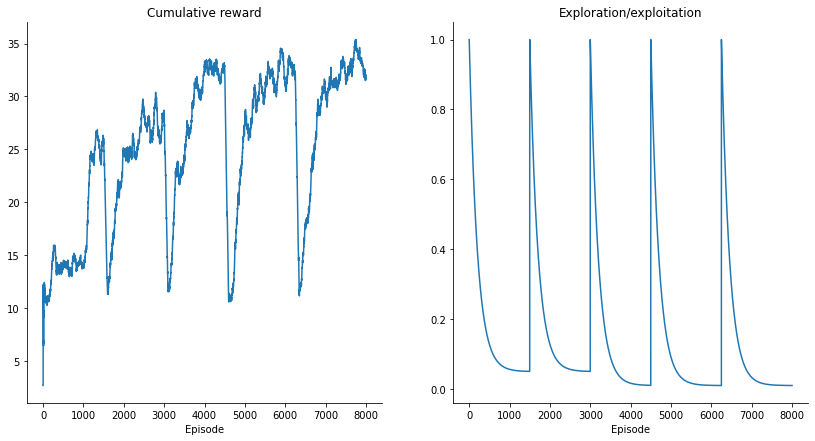

In [15]:
stats = pre_trained.stats  # Get saved training stats from pre-trained agent
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(sliding_mean(stats["episode_rewards"], 100))
plt.xlabel('Episode')
plt.title('Cumulative reward')
despine()

plt.subplot(1, 2, 2)
plt.plot(stats["eps"])
plt.xlabel('Episode')
plt.title('Exploration/exploitation')
despine()

### Exercise A.4

Generate a random observation

In [20]:
s = env.reset()
env.render()
print(s)

[[ 1.          1.          0.5         0.41666667  0.        ]
 [ 1.          0.13645794  0.25       -0.0334208   0.        ]
 [ 1.          0.25803768 -0.25       -0.06083438  0.        ]
 [ 1.          0.39315275  0.         -0.05026475  0.        ]
 [ 1.          0.54598202 -0.25       -0.02960748  0.        ]]


Evaluate the state-value function for the pre-trained model

In [21]:
print(pre_trained.Q(s))

[[4.4932747 4.6725516 4.624316  4.972962  4.590329 ]]


Define you own observation $s\in \mathbb{R}^{5\times 5}$ and evaluate

In [22]:
s = np.array([[1, 0, 0, 0, 0],
              [1, 0, 0, 0, 0],
              [1, 0, 0, 0, 0],
              [1, 0, 0, 0, 0],
              [1, 0, 0, 0, 0]])
print(pre_trained.Q(s))

[[1.651787   0.97883165 1.5335904  1.2760525  1.3009435 ]]


Run the pre-trained model (try your own also)

In [24]:
# Generate a random seed between 0 and 1000; save for later if you find an interesting scenario
seed = np.random.randint(0, 1000)
# env.config["vehicles_density"] = 1.25  # Increase density, default = 1.0
env.seed(seed)
s = env.reset()
done = False
tot_reward = 0
while not done:
    a = pre_trained.act(s)
    s, r, done, info = env.step(a)
    tot_reward += r
    env.render()
env.close()
print(f"Finished episode with total reward {tot_reward:.1f}")

Finished episode with total reward 38.5


### Exercise A.5

This exercise evaluates how the value faunction $V(s)$ connects to the action-value functio $Q(s, a)$ in a scenario.

In [30]:
# seed = np.random.randint(0, 1000)
env.seed(seed)
s = env.reset()
done = False
tot_reward = 0
s_scenario = []  # List with all states during sceneario execution
while not done:
    s_scenario.append(s)

    a = pre_trained.act(s)
    s, r, done, info = env.step(a)
    env.render()

    tot_reward += r
    
env.close()
print(f"Finished episode with total reward {tot_reward:.1f}")

Finished episode with total reward 37.5


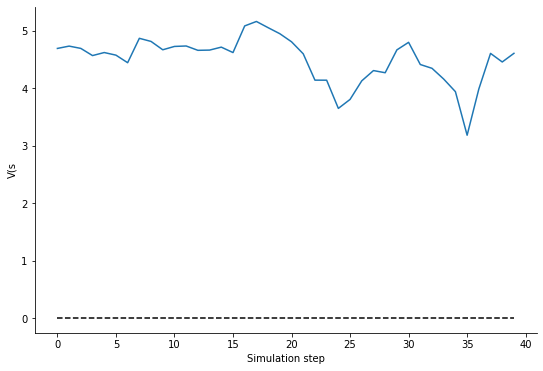

In [32]:
V = [np.max(pre_trained.Q(si)) for si in s_scenario]
V_uppper_bound = 0  # YOUR CODE HERE; answer to question on upper bound for V(s), Q(s, a)
fig = plt.figure(20, clear=True, figsize=(9, 6))
plt.plot(V)
plt.plot(np.ones(len(V)) * V_uppper_bound, 'k--')
plt.xlabel('Simulation step')
plt.ylabel('V(s')
despine()

### Exercise A.6